In [2]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


In [3]:
pip install split-folders


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders

# Path to the original dataset
input_folder = '/kaggle/input/mango1/Mango/archive'

# Output folder for split datasets
output_folder = '/kaggle/working/split_dataset'

# Split into 80% train, 10% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 6000 files [00:34, 173.88 files/s]


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size =64
img_size = 224

# Create separate data generators for each split
train_datagen = ImageDataGenerator(rescale=1/255.,    rotation_range=30,      # Rotate images by up to 30 degrees
    width_shift_range=0.1,  # Shift width by up to 10%
    height_shift_range=0.1, # Shift height by up to 10%
    zoom_range=0.1,         # Zoom images in by up to 10%
    fill_mode='nearest' )    # Fill any missing pixels within the frame)

val_test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data from the split folders
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/val',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 4800 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import Input, Reshape, LSTM, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base Xception model with random initialization
    baseModel = Xception(weights=None, include_top=False, input_tensor=input_layer)

    # Do not load pretrained weights — training from scratch
    for layer in baseModel.layers:
        layer.trainable = True  # All layers are trainable from scratch

    # Feature extraction output
    x = baseModel.output  # (None, 7, 7, 2048)

    # Reshape for LSTM
    x = Reshape((49, 2048))(x)

    # LSTM + Dropout
    x = LSTM(512, return_sequences=False, activation='relu', name='lstm')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    # Fully connected layer 1
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # Fully connected layer 2
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(6, activation='softmax', name='predictions')(x)

    # Model definition
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

# Create the model
model = Combined_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 482,316,846 (1.80 GB)

 Trainable params: 427,872,262 (1.59 GB)

 Non-trainable params: 54,444,584 (207.69 MB)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
model_name = "mango1.keras"  # Changed from model.h5 to model.keras

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_accuracy",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_accuracy',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [8]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732043785.932238     127 service.cc:145] XLA service 0x5816c9c275e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732043785.932305     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732043785.932312     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732043810.513496     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7194 - loss: 1.3563
Epoch 1: val_accuracy improved from inf to 0.81000, saving model to mango1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.7203 - loss: 1.3505 - val_accuracy: 0.8100 - val_loss: 0.4655 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8751 - loss: 0.4278
Epoch 2: val_accuracy did not improve from 0.81000
75/75 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.8752 - loss: 0.4270 - val_accuracy: 0.8250 - val_loss: 0.4257 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9003 - loss: 0.2930
Epoch 3: val_accuracy improved from 0.81000 to 0.76667, saving model to mango1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9002 - loss: 0.2930 - val_accuracy: 0.7667 - val_loss: 0.6088 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9060 - loss: 0.2687
Epoch 4: val_accuracy did not 

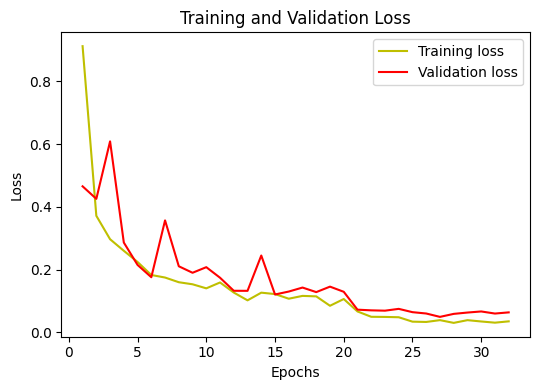

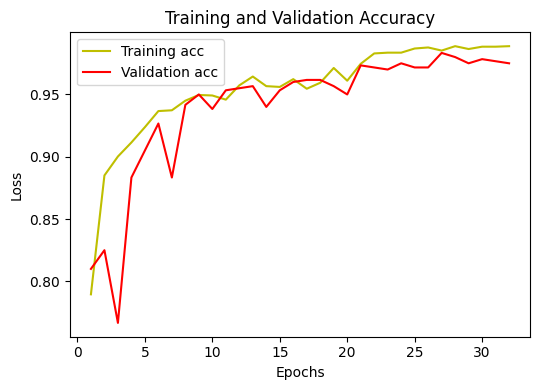

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
)
print(f"Test Accuracy: {test_accuracy:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9715 - loss: 0.0719
Test Accuracy: 0.98


In [11]:
# Use the test generator for final evaluation
y_test = test_generator.classes  # True class labels for the test set

# Get predictions from the model for the test set
y_pred = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       100
           1       0.97      0.94      0.95       100
           2       0.98      0.97      0.97       100
           3       0.98      0.99      0.99       100
           4       1.00      0.99      0.99       100
           5       0.99      1.00      1.00       100

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 962ms/step


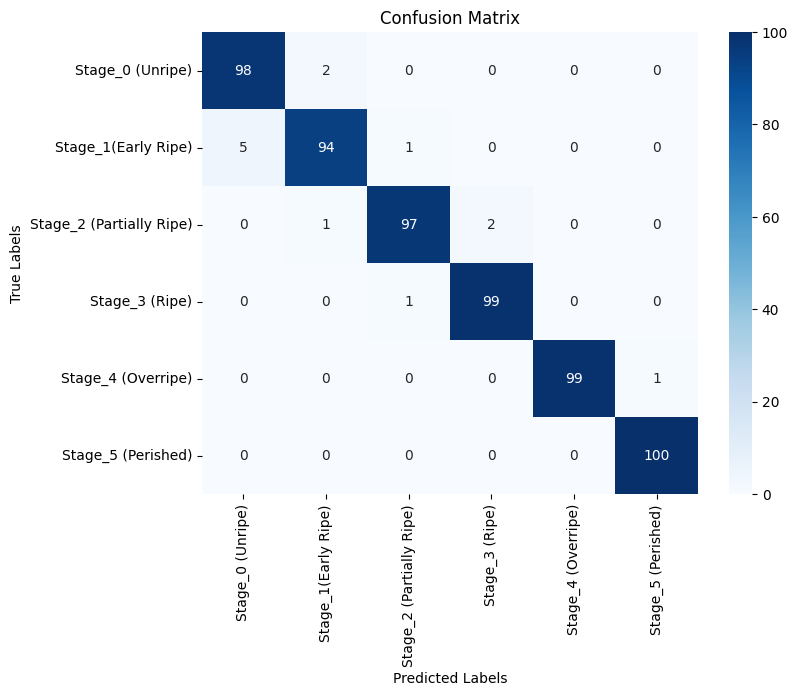

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predicted labels for the test set
y_test = test_generator.classes  # True class labels for the test set
y_pred = model.predict(test_generator)  # Get predictions
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [14]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [15]:
filenames = test_generator.filenames

In [16]:
# Create a DataFrame with filenames, actual, and predicted labels
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_test  # Correcting this to use y_test instead of y_val
val_df['predicted'] = y_pred

# Map the integer labels to the actual class names using the indices dictionary
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])

# Add a column 'Same' to indicate whether actual and predicted labels match
val_df['Same'] = val_df['actual'] == val_df['predicted']

# Display the first 10 rows of the DataFrame
val_df.head(10)

filename            actual         predicted  Same
0  Stage_0 (Unripe)/UR103.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
1  Stage_0 (Unripe)/UR120.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
2  Stage_0 (Unripe)/UR122.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
3  Stage_0 (Unripe)/UR125.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
4  Stage_0 (Unripe)/UR127.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
5  Stage_0 (Unripe)/UR138.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
6   Stage_0 (Unripe)/UR14.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
7  Stage_0 (Unripe)/UR162.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
8  Stage_0 (Unripe)/UR170.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True
9  Stage_0 (Unripe)/UR171.jpg  Stage_0 (Unripe)  Stage_0 (Unripe)  True

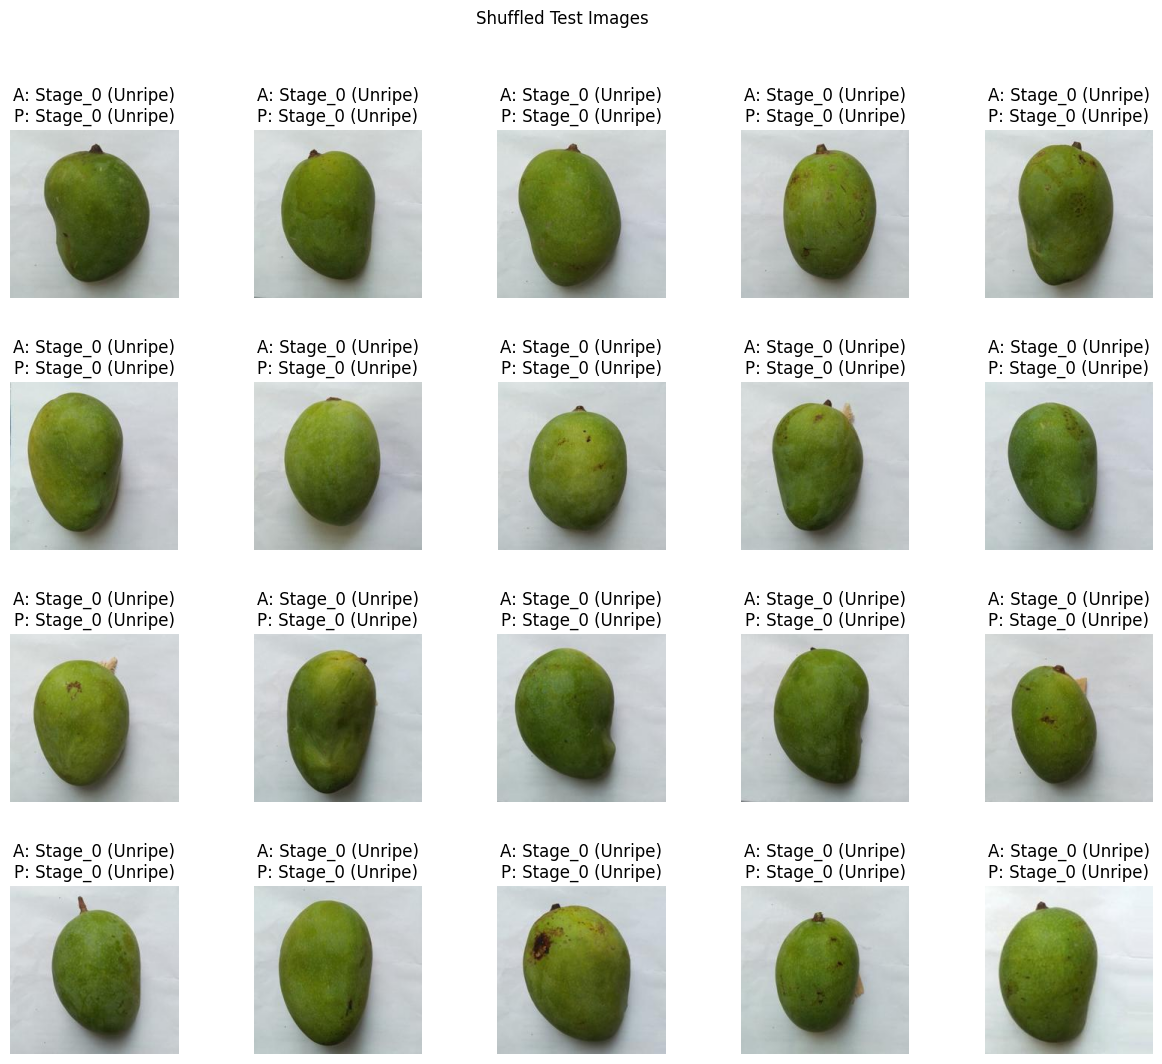

In [17]:
def readImage(path, img_size=224):
    """Reads an image, resizes it, and normalizes it."""
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.  # Normalize the image to [0, 1] range
    return img

def display_images(temp_df, title="Images", max_images=25, dataset_dir='/kaggle/input/new-banana/dataset/test'):
    """Displays a grid of images from the DataFrame."""
    # Reset the index of the DataFrame to ensure continuity
    temp_df = temp_df.reset_index(drop=True)
    
    # Determine the number of images to display (limited by max_images)
    num_images = min(len(temp_df), max_images)
    
    # Calculate the number of rows needed for the subplots (assuming 5 columns)
    num_rows = (num_images + 4) // 5  # Add 4 for rounding up
    
    plt.figure(figsize=(15, 3 * num_rows))  # Adjust the figure size to fit all images
    
    for i in range(num_images):
        plt.subplot(num_rows, 5, i + 1)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        
        # Ensure the path includes the subdirectory structure (e.g., 'Stage_0 (Unripe)/UR103.jpg')
        image_path = f"{dataset_dir}/{temp_df.filename[i]}"
        
        # Check if the file exists before attempting to load the image
        if os.path.exists(image_path):
            # Load the image using the `readImage` function
            image = readImage(image_path)
            
            # Display the image
            plt.imshow(image)
            plt.title(f'A: {temp_df.actual[i]}\nP: {temp_df.predicted[i]}')
            plt.axis('off')  # Hide axis for a clean look
        else:
            plt.text(0.5, 0.5, "File not found", horizontalalignment='center', verticalalignment='center')
            plt.axis('off')  # Hide axis if image is not found
            
    plt.suptitle(title)  # Title for the entire plot
    plt.show()

# Example usage (display shuffled images from the test dataset)
display_images(val_df, title="Shuffled Test Images", max_images=20, dataset_dir='/kaggle/working/split_dataset/test')


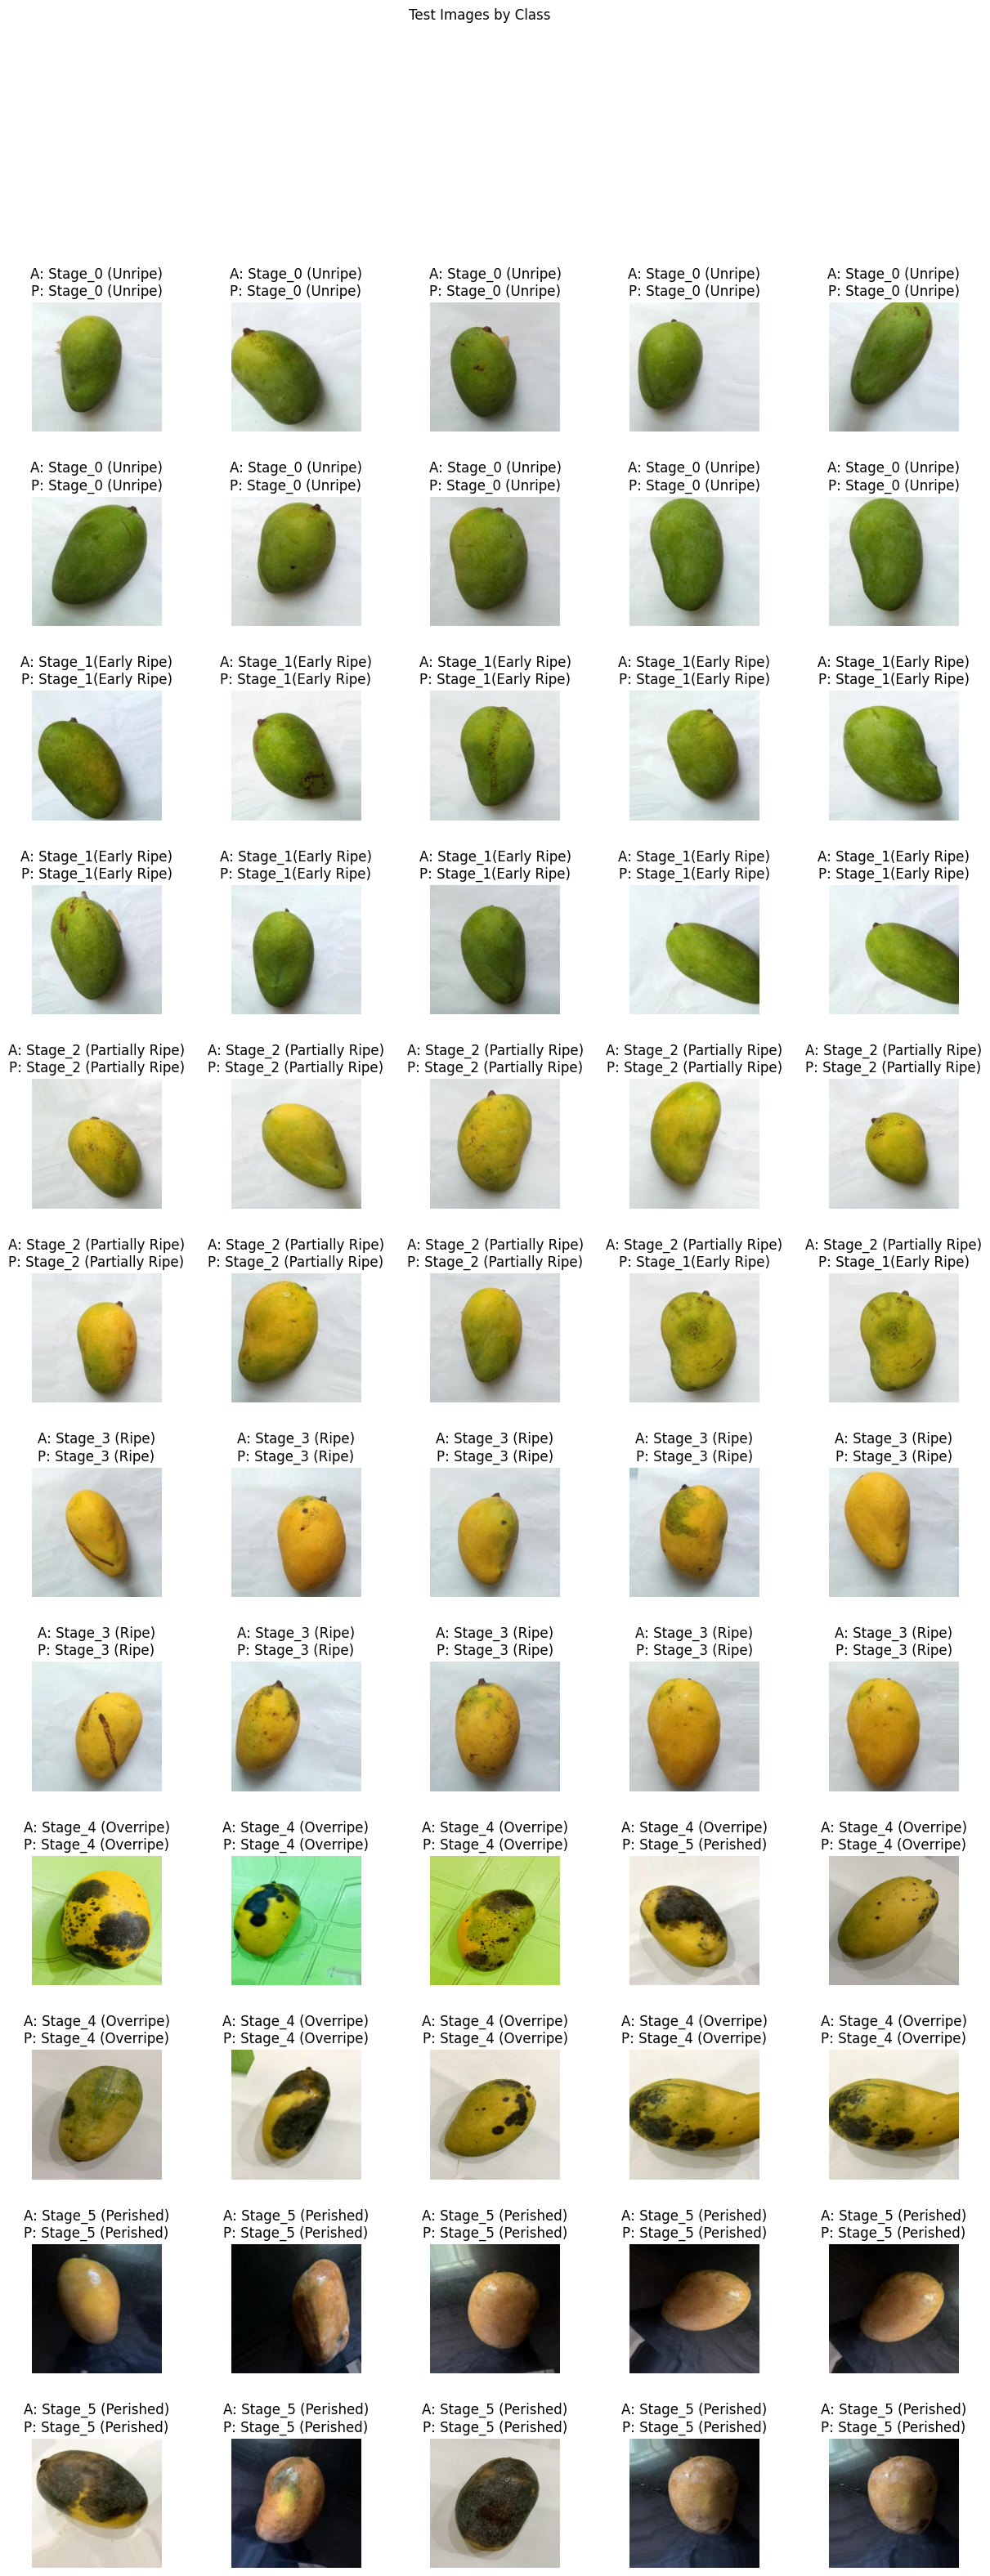

In [18]:
def display_images_per_class(temp_df, title="Images by Class", images_per_class=10, dataset_dir='/kaggle/working/split_dataset/test'):
    """
    Displays a specified number of images for each class from the DataFrame.
    
    Parameters:
    - temp_df: DataFrame containing filenames, actual labels, and predicted labels.
    - title: Title for the entire plot.
    - images_per_class: Number of images to display per class.
    - dataset_dir: Path to the dataset directory.
    """
    # Get the unique classes
    classes = temp_df['actual'].unique()
    
    # Determine the number of rows needed for the subplots (5 columns)
    num_classes = len(classes)
    num_images = num_classes * images_per_class
    num_rows = (num_images + 4) // 5  # Add 4 for rounding up
    
    plt.figure(figsize=(15, 3 * num_rows))  # Adjust the figure size to fit all images
    
    subplot_index = 1  # Initialize subplot index
    
    for cls in classes:
        # Filter the DataFrame for the current class and sample the desired number of images
        class_df = temp_df[temp_df['actual'] == cls].sample(n=images_per_class, replace=True, random_state=42)
        
        for _, row in class_df.iterrows():
            plt.subplot(num_rows, 5, subplot_index)
            plt.subplots_adjust(hspace=0.5, wspace=0.3)
            
            # Ensure the path includes the subdirectory structure (e.g., 'Stage_0 (Unripe)/UR103.jpg')
            image_path = f"{dataset_dir}/{row['filename']}"
            
            # Check if the file exists before attempting to load the image
            if os.path.exists(image_path):
                # Load the image using the `readImage` function
                image = readImage(image_path)
                
                # Display the image
                plt.imshow(image)
                plt.title(f'A: {row.actual}\nP: {row.predicted}')
                plt.axis('off')  # Hide axis for a clean look
            else:
                plt.text(0.5, 0.5, "File not found", horizontalalignment='center', verticalalignment='center')
                plt.axis('off')  # Hide axis if image is not found
            
            subplot_index += 1  # Increment subplot index
    
    plt.suptitle(title)  # Title for the entire plot
    plt.show()

# Example usage (display 10 images per class from the test dataset)
display_images_per_class(
    temp_df=val_df, 
    title="Test Images by Class", 
    images_per_class=10, 
    dataset_dir='/kaggle/working/split_dataset/test'
)


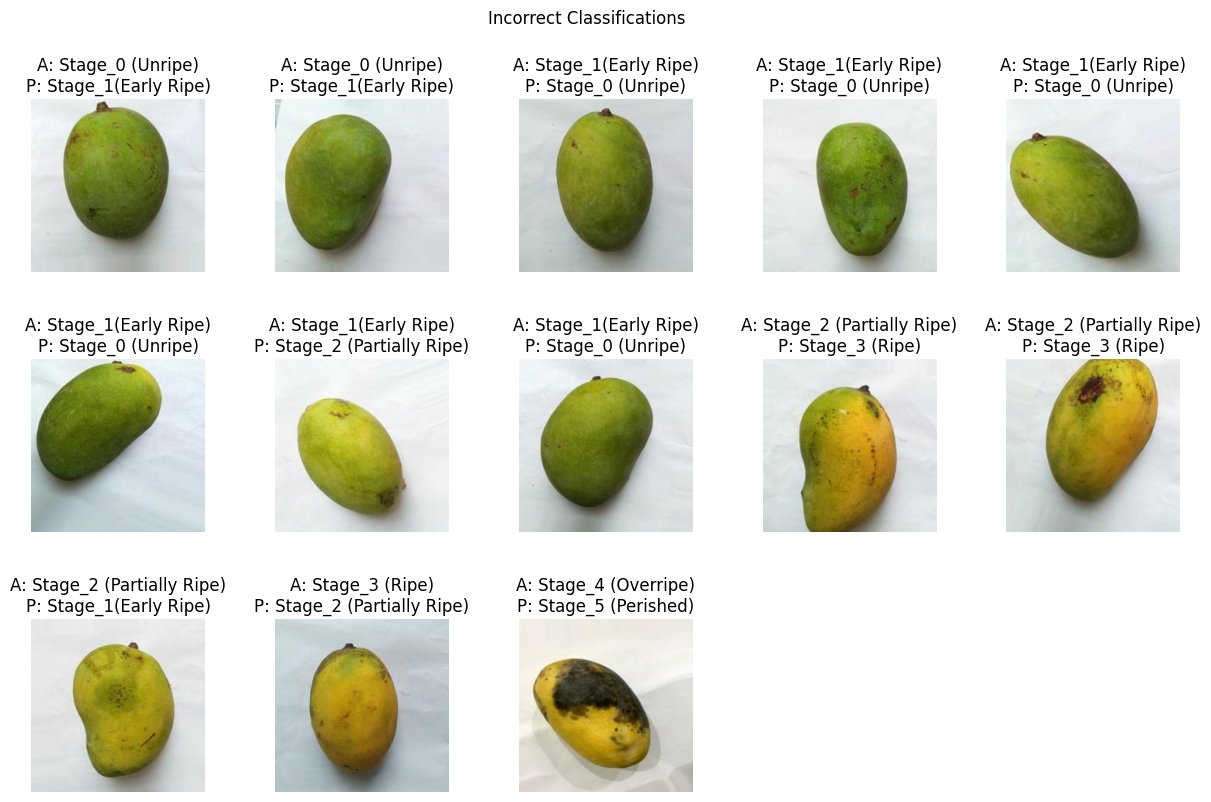

In [19]:
def display_incorrect_predictions(temp_df, dataset_dir, max_images=25, img_size=224):
    """
    Displays images that were incorrectly classified by the model.
    
    Parameters:
    - temp_df: DataFrame containing filenames, actual labels, and predicted labels.
    - dataset_dir: Path to the test dataset directory.
    - max_images: Maximum number of images to display.
    - img_size: Target size for image resizing.
    """
    # Filter the DataFrame to only include incorrect predictions
    incorrect_df = temp_df[temp_df['actual'] != temp_df['predicted']].reset_index(drop=True)
    
    if incorrect_df.empty:
        print("No incorrect predictions to display!")
        return
    
    # Determine the number of images to display (up to max_images)
    num_images = min(len(incorrect_df), max_images)
    num_rows = (num_images + 4) // 5  # Calculate rows for 5 columns
    
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i in range(num_images):
        plt.subplot(num_rows, 5, i + 1)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        
        # Construct the file path
        image_path = f"{dataset_dir}/{incorrect_df.filename[i]}"
        
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            plt.text(0.5, 0.5, "File not found", horizontalalignment='center', verticalalignment='center')
            plt.axis('off')
            continue
        
        # Load and display the image
        image = readImage(image_path, img_size=img_size)
        plt.imshow(image)
        plt.title(f"A: {incorrect_df.actual[i]}\nP: {incorrect_df.predicted[i]}")
        plt.axis('off')
    
    plt.suptitle("Incorrect Classifications")
    plt.show()

# Example usage
display_incorrect_predictions(
    temp_df=val_df, 
    dataset_dir='/kaggle/working/split_dataset/test', 
    max_images=20, 
    img_size=224
)


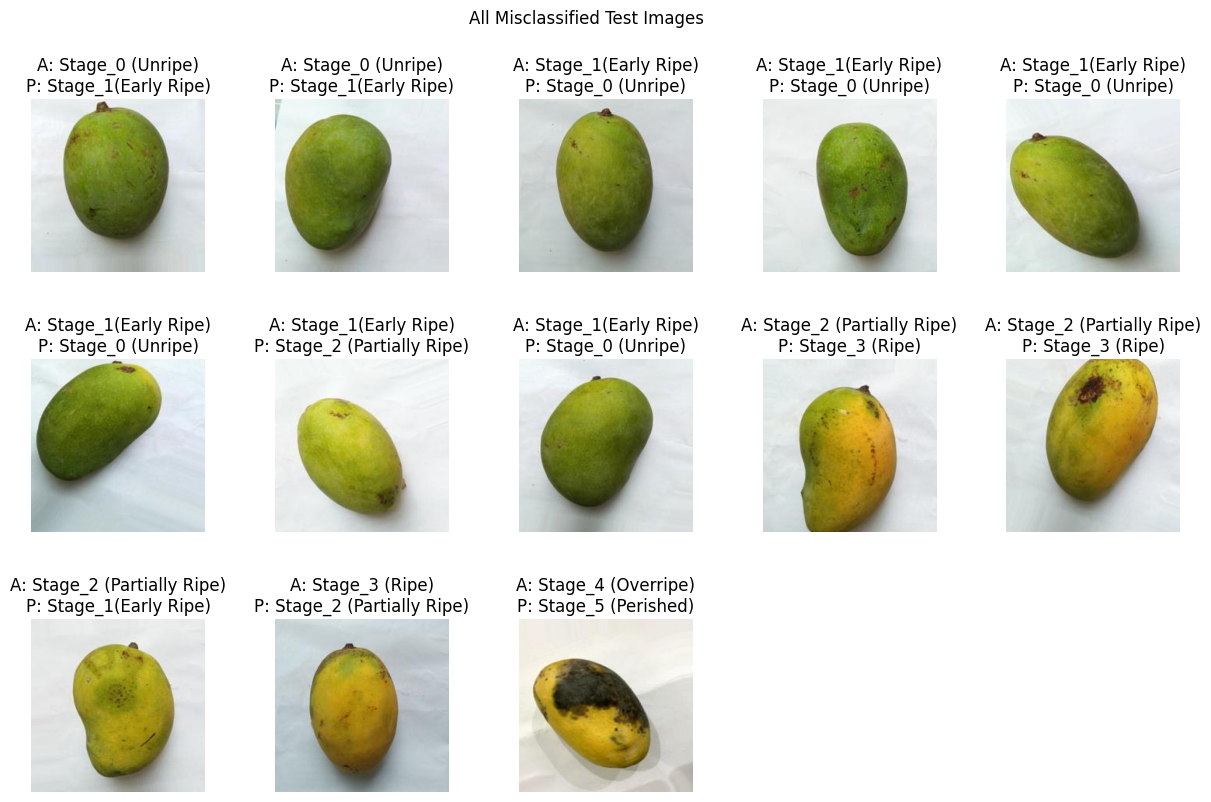

In [20]:
def display_all_misclassified_images(temp_df, title="All Misclassified Images", max_images=50, dataset_dir='/kaggle/working/split_dataset/test'):
    """
    Displays all misclassified images from the dataset.
    
    Parameters:
    - temp_df: DataFrame containing filenames, actual labels, and predicted labels.
    - title: Title for the plot.
    - max_images: Maximum number of misclassified images to display.
    - dataset_dir: Path to the dataset directory.
    """
    # Filter the DataFrame to include only misclassified rows
    misclassified_df = temp_df[temp_df['actual'] != temp_df['predicted']]
    
    # Limit the number of images to display
    num_images = min(len(misclassified_df), max_images)
    
    # Calculate the number of rows and columns for the plot
    num_columns = 5
    num_rows = (num_images + num_columns - 1) // num_columns  # Round up
    
    plt.figure(figsize=(15, 3 * num_rows))  # Adjust the figure size
    
    for i, (_, row) in enumerate(misclassified_df.iterrows()):
        if i >= max_images:  # Stop if we've reached the max number of images
            break
        
        plt.subplot(num_rows, num_columns, i + 1)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, row['filename'])
        
        # Check if the file exists
        if os.path.exists(image_path):
            # Load and display the image
            image = readImage(image_path)
            plt.imshow(image)
            plt.title(f'A: {row.actual}\nP: {row.predicted}')
            plt.axis('off')
        else:
            # Handle missing files
            plt.text(0.5, 0.5, "File not found", horizontalalignment='center', verticalalignment='center')
            plt.axis('off')
    
    plt.suptitle(title)  # Title for the entire plot
    plt.show()

# Example usage
display_all_misclassified_images(
    temp_df=val_df, 
    title="All Misclassified Test Images", 
    max_images=50,  # Maximum number of images to display
    dataset_dir='/kaggle/working/split_dataset/test'  # Path to the test dataset
)

In [28]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # Adjust to create a model that outputs the desired convolutional layer's output
    grad_model = Model(inputs=model.inputs, 
                       outputs=[model.get_layer('conv2d_3').output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.matmul(conv_outputs, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds


In [29]:
import matplotlib.cm as cm

In [30]:
val_df

filename              actual           predicted  Same
0     Stage_0 (Unripe)/UR103.jpg    Stage_0 (Unripe)    Stage_0 (Unripe)  True
1     Stage_0 (Unripe)/UR120.jpg    Stage_0 (Unripe)    Stage_0 (Unripe)  True
2     Stage_0 (Unripe)/UR122.jpg    Stage_0 (Unripe)    Stage_0 (Unripe)  True
3     Stage_0 (Unripe)/UR125.jpg    Stage_0 (Unripe)    Stage_0 (Unripe)  True
4     Stage_0 (Unripe)/UR127.jpg    Stage_0 (Unripe)    Stage_0 (Unripe)  True
..                           ...                 ...                 ...   ...
595  Stage_5 (Perished)/P967.jpg  Stage_5 (Perished)  Stage_5 (Perished)  True
596   Stage_5 (Perished)/P98.jpg  Stage_5 (Perished)  Stage_5 (Perished)  True
597  Stage_5 (Perished)/P984.jpg  Stage_5 (Perished)  Stage_5 (Perished)  True
598  Stage_5 (Perished)/P987.jpg  Stage_5 (Perished)  Stage_5 (Perished)  True
599  Stage_5 (Perished)/P990.jpg  Stage_5 (Perished)  Stage_5 (Perished)  True

[600 rows x 4 columns]

In [31]:
def gradCAMImage(image):
    path = f"/kaggle/working/split_dataset/test/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [33]:
def gradcam_of_images(correct_class=True):
    """Generate Grad-CAM visualizations for all classes"""
    grad_images = []
    titles = []
    
    # Get all unique classes
    classes = sorted(val_df['actual'].unique())
    
    for class_name in classes:
        # Filter for current class and correct/incorrect predictions
        class_df = val_df[
            (val_df['actual'] == class_name) & 
            (val_df['Same'] == correct_class)
        ].reset_index(drop=True)
        
        # Get 2 random samples from this class
        num_images = min(len(class_df),3)
        if num_images > 0:
            sampled_df = class_df.sample(n=num_images, random_state=42)
            
            for i in range(num_images):
                image_path = sampled_df.iloc[i]['filename']
                grad_image = gradCAMImage(image_path)
                grad_images.append(grad_image)
                titles.append(f"A: {sampled_df.iloc[i]['actual']}\nP: {sampled_df.iloc[i]['predicted']}")
    
    return grad_images, titles

def display_heatmaps(classified_images, titles):
    """Display heatmap visualizations in a grid"""
    num_images = len(classified_images)
    rows = (num_images + 4) // 5  # Calculate rows needed, assuming 5 columns
    
    plt.figure(figsize=(20, 4 * rows))  # Adjust figure size based on number of rows
    
    for i in range(num_images):
        plt.subplot(rows, 5, i + 1)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
        plt.axis('off')
    
    plt.show()

Correctly Classified Images:


/tmp/ipykernel_30/2346800869.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


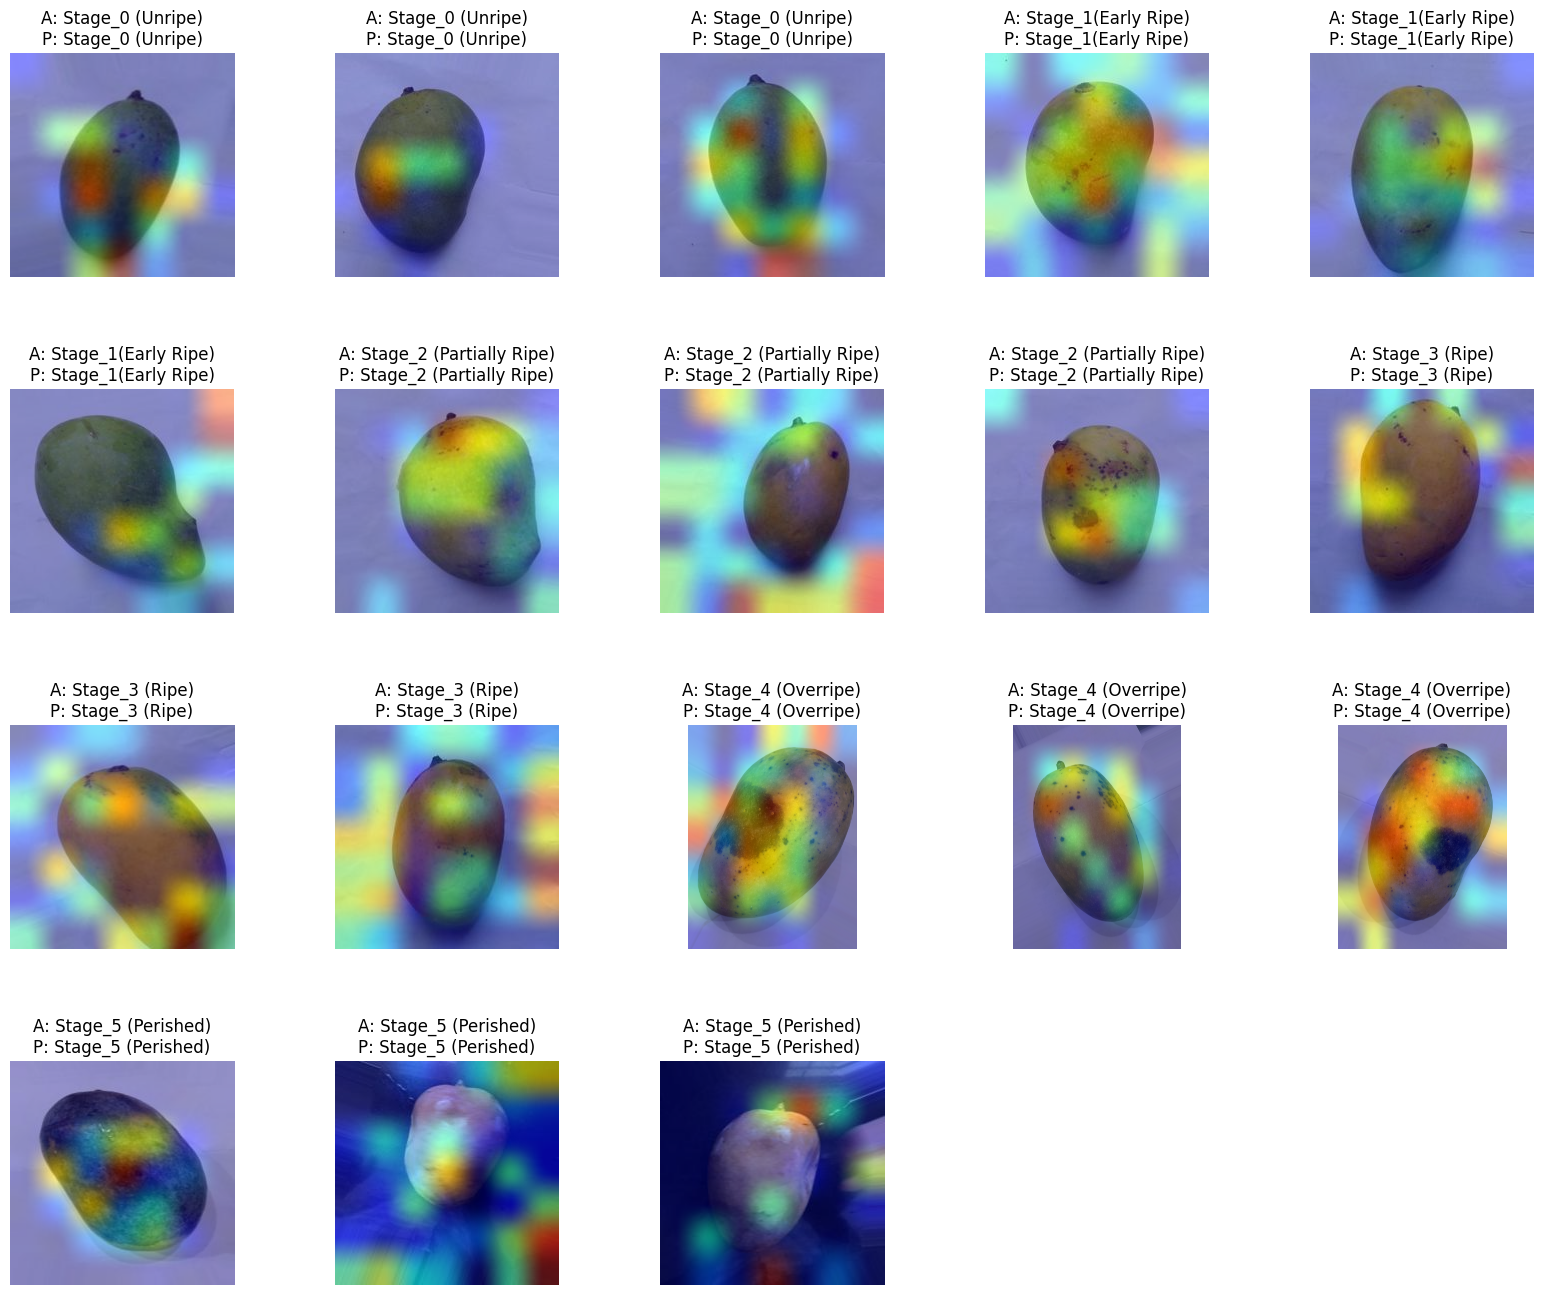


Misclassified Images:


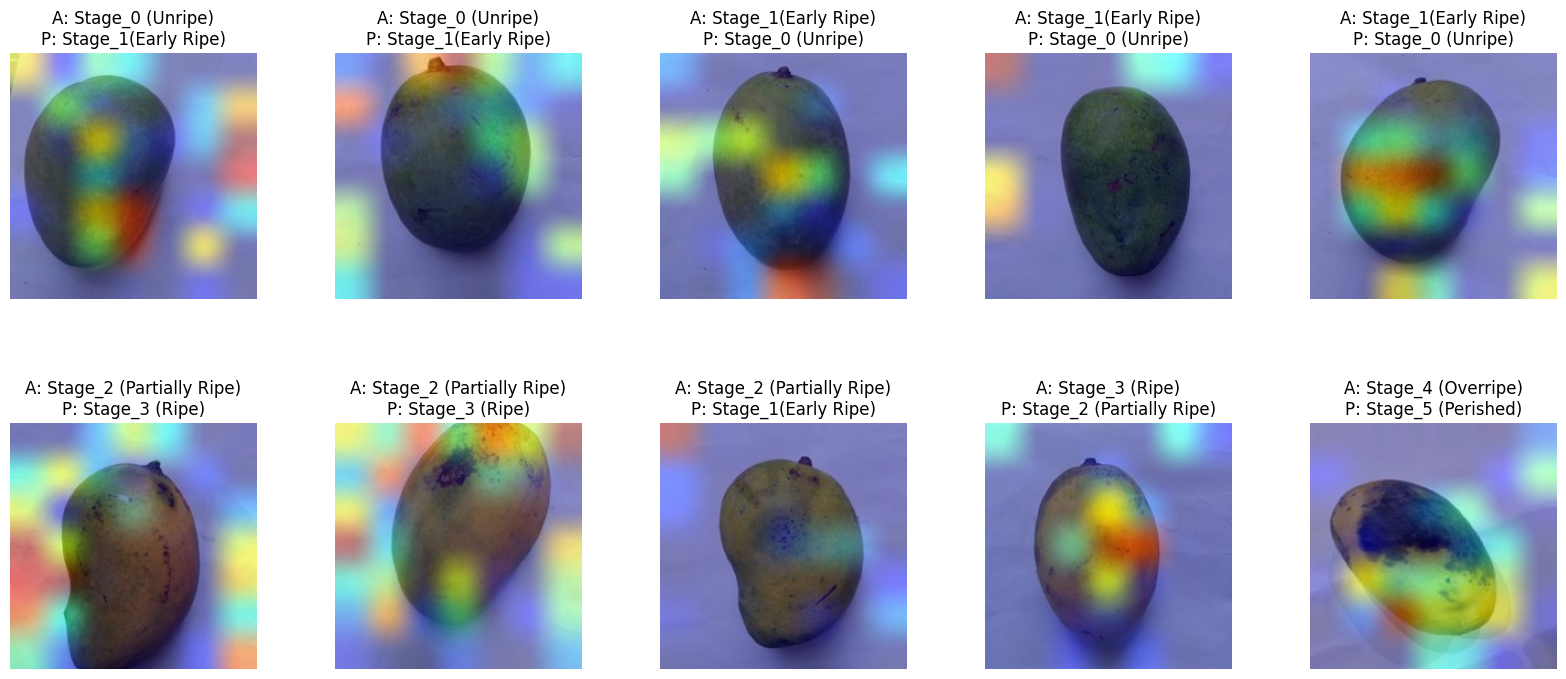

In [34]:
def visualize_all_gradcams():
    """Generate and display all Grad-CAM visualizations"""
    # Get correctly classified images
    print("Correctly Classified Images:")
    correctly_classified, c_titles = gradcam_of_images(correct_class=True)
    display_heatmaps(correctly_classified, c_titles)
    
    # Get misclassified images
    print("\nMisclassified Images:")
    misclassified, m_titles = gradcam_of_images(correct_class=False)
    display_heatmaps(misclassified, m_titles)

# Run the visualization
visualize_all_gradcams()